# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries

import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Load the dataset.

In [3]:
# Load and unzip the dataset

# Path to zipped dataset and extraction target
zip_path     = r"data\data.zip"
extract_dir  = r"data\data"

# Unzip contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Dataset extracted to {extract_dir}")

# Set a variable for where the class‑folders now live
data_dir = r"data\data"

Dataset extracted to data\data


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images

def load_and_crop_images(root_dir, target_size=(128, 128)):
    """
    Traverse each class subfolder in root_dir, load images,
    center‑crop them to square, resize to target_size, and
    return arrays of images and corresponding labels.
    """
    X, y = [], []
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            img_path = os.path.join(class_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            # Convert BGR → RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            # Center‑crop to square
            m = min(h, w)
            top  = (h - m) // 2
            left = (w - m) // 2
            img = img[top:top+m, left:left+m]
            # Resize to target_size
            img = cv2.resize(img, target_size)
            X.append(img)
            y.append(class_name)
    return np.array(X), np.array(y)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Images array shape: (7625, 128, 128, 3)
Labels array shape: (7625,)
Unique classes (7): ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


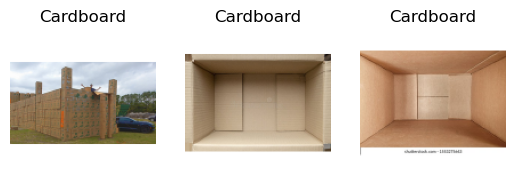

Class → integer mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


In [5]:
# Get the images and their labels

X, y = load_and_crop_images(data_dir, target_size=(128, 128))

# Verify loading
print(f"Images array shape: {X.shape}")       # (n_samples, 128, 128, 3)
print(f"Labels array shape: {y.shape}")       # (n_samples,)
print(f"Unique classes ({len(np.unique(y))}): {np.unique(y)}")

# Display a few samples to ensure labels match images
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')
plt.show()

# Normalize pixel values to [0,1]
X = X.astype('float32') / 255.0

# Encode string labels to integer labels
le = LabelEncoder()
y_int = le.fit_transform(y)
print("Class → integer mapping:", dict(zip(le.classes_, le.transform(le.classes_))))



Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

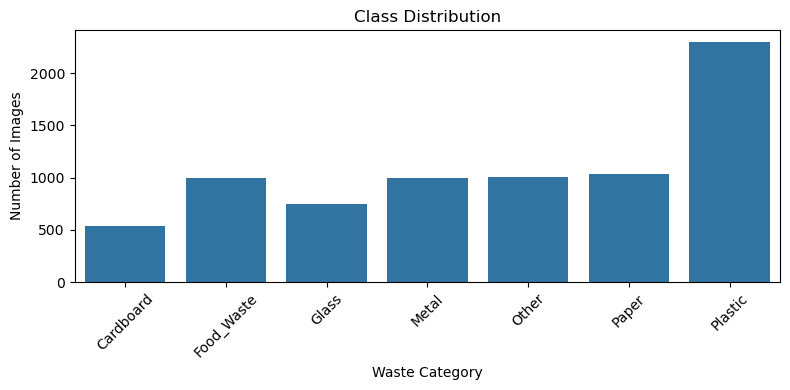

In [6]:
# Visualise Data Distribution

# Count images per class
counts = np.bincount(y_int)
classes = le.classes_

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=classes, y=counts)
plt.title("Class Distribution")
plt.xlabel("Waste Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

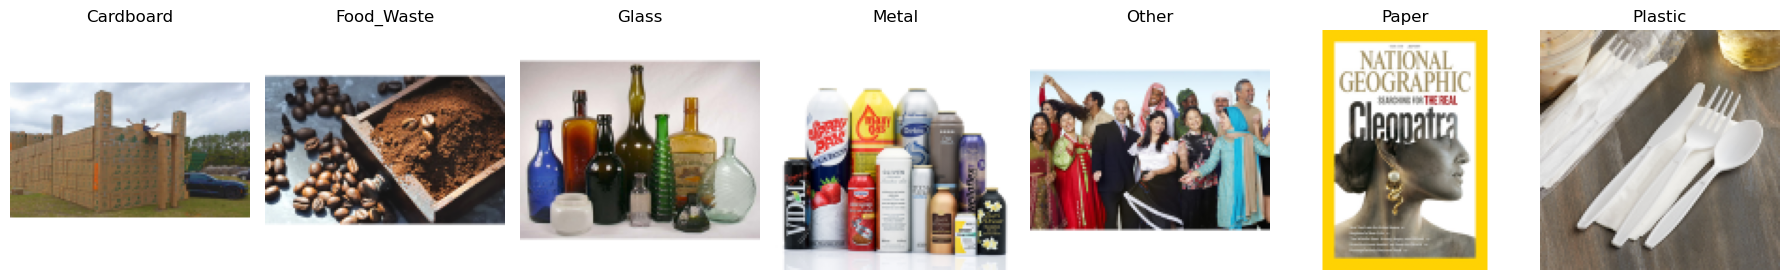

In [7]:
# Visualise Sample Images (across different labels)

classes = le.classes_
fig, axes = plt.subplots(1, len(classes), figsize=(18, 4))
for i, cls in enumerate(classes):
    idx = np.where(y_int == i)[0][0]      # first index for class i
    axes[i].imshow(X[idx])
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set

# Gather original dimensions
dims = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path): continue
    for fname in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path, fname))
        if img is None: continue
        dims.append(img.shape[:2])

dims = np.array(dims)
print(f"Smallest dimensions: {tuple(dims.min(axis=0))}")
print(f"Largest dimensions: {tuple(dims.max(axis=0))}")


Smallest dimensions: (256, 256)
Largest dimensions: (256, 256)


In [9]:
# Resize the image dimensions

target_size = (128, 128)
X = np.array([cv2.resize(img, target_size) for img in X])
print("Resized all images to:", X.shape[1:])

Resized all images to: (128, 128, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably

# Integer‑encode string labels
le = LabelEncoder()
y_int = le.fit_transform(y)
print("Class → Integer mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# One‑hot encode for model training
y_cat = to_categorical(y_int)
print("One‑hot encoded labels shape:", y_cat.shape)

Class → Integer mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
One‑hot encoded labels shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat,
    test_size=0.20,
    stratify=y_int,
    random_state=42
)

# Verify shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")

X_train: (6100, 128, 128, 3), y_train: (6100, 7)
X_val:   (1525, 128, 128, 3),   y_val:   (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [12]:
# Build and compile the model

model = Sequential([
    # 1st conv block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # 2nd conv block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # 3rd conv block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Fully connected classifier
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,831 (32.37 MB)

 Trainable params: 8,484,871 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [13]:
# Training

# Define callbacks
es = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True, 
    verbose=1
)
mc = ModelCheckpoint(
    filepath='best_cnn_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

# Train
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es, mc]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.2974 - loss: 2.2418
Epoch 1: val_accuracy improved from -inf to 0.14885, saving model to best_cnn_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 431ms/step - accuracy: 0.2977 - loss: 2.2404 - val_accuracy: 0.1489 - val_loss: 7.7592
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.4185 - loss: 1.6175
Epoch 2: val_accuracy did not improve from 0.14885
191/191 ━━━━━━━━━━━━━━━━━━━━ 77s 404ms/step - accuracy: 0.4185 - loss: 1.6173 - val_accuracy: 0.1449 - val_loss: 8.7370
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.4935 - loss: 1.4060
Epoch 3: val_accuracy improved from 0.14885 to 0.29639, saving model to best_cnn_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.4934 - loss: 1.4064 - val_accuracy: 0.2964 - val_loss: 4.0034
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.5020 - loss: 1.3698
Epoch 4: val_accuracy improved from 0.29639 to 0.37180, saving model to best_cnn_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.5019 - loss: 1.3701 - val_accuracy: 0.3718 - val_loss: 2.0112
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5159 - loss: 1.3386
Epoch 5: val_accuracy improved from 0.37180 to 0.39082, saving model to best_cnn_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 449ms/step - accuracy: 0.5160 - loss: 1.3384 - val_accuracy: 0.3908 - val_loss: 3.8853
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6033 - loss: 1.1122
Epoch 6: val_accuracy improved from 0.39082 to 0.42623, saving model to best_cnn_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 438ms/step - accuracy: 0.6032 - loss: 1.1122 - val_accuracy: 0.4262 - val_loss: 2.6669
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6178 - loss: 1.0646
Epoch 7: val_accuracy did not improve from 0.42623
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.6178 - loss: 1.0645 - val_accuracy: 0.3725 - val_loss: 3.4904
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Validation Loss: 2.0112
Validation Accuracy: 0.3718
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step

Classification Report:

              precision    recall  f1-score   support

   Cardboard     0.7391    0.1574    0.2595       108
  Food_Waste     0.3959    0.3900    0.3929       200
       Glass     0.3151    0.1533    0.2063       150
       Metal     0.2931    0.5100    0.3723       200
       Other     0.2071    0.3762    0.2671       202
       Paper     0.5455    0.2330    0.3265       206
     Plastic     0.5198    0.4858    0.5023       459

    accuracy                         0.3718      1525
   macro avg     0.4308    0.3294    0.3324      1525
weighted avg     0.4313    0.3718    0.3697      1525



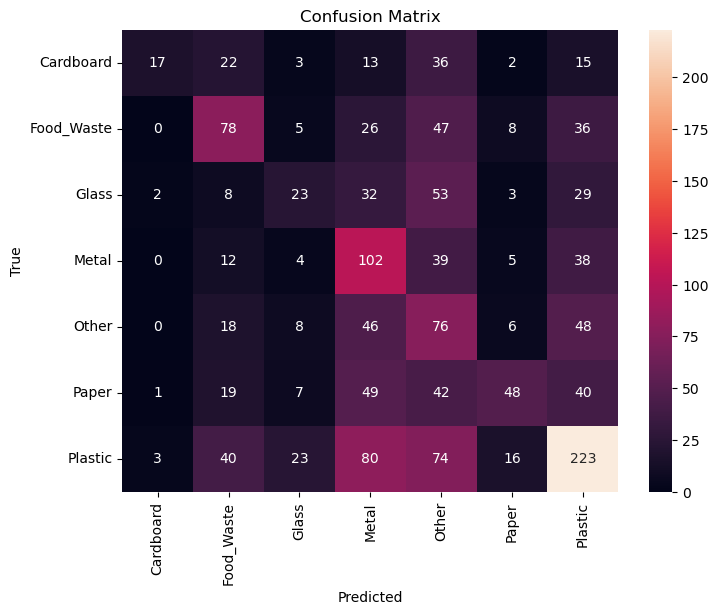

In [14]:
# Evaluate on the test set; display suitable metrics

# 1. Evaluate loss & accuracy
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# 2. Predictions and integer labels
y_pred_probs = model.predict(X_val)
y_pred_int   = np.argmax(y_pred_probs, axis=1)
y_true_int   = np.argmax(y_val, axis=1)

# 3. Classification report
y_pred_labels = le.inverse_transform(y_pred_int)
y_true_labels = le.inverse_transform(y_true_int)
print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

# 4. Confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [15]:
# Define augmentation steps to augment images

# Define augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,        # randomly rotate images by up to 20°
    width_shift_range=0.1,    # randomly shift images horizontally by 10% of width
    height_shift_range=0.1,   # randomly shift images vertically by 10% of height
    shear_range=0.1,          # shear transformations
    zoom_range=0.1,           # zoom in/out by up to 10%
    horizontal_flip=True,     # randomly flip images horizontally
    fill_mode='nearest'       # fill in new pixels after transform
)

# For validation, only rescale
val_datagen = ImageDataGenerator()

# Create generators
train_gen = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)
val_gen = val_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [16]:
# Create a function to augment the images

# —— Cell 12 (updated): Corrected Augmentation Function ——
def augment_class_images(X_class, y_class, augmentor, n_samples):
    """
    Augment images from a single class to generate n_samples new images.
    """
    X_augmented, y_augmented = [], []
    gen = augmentor.flow(X_class, y_class, batch_size=1)
    
    for _ in range(n_samples):
        x_new, y_new = next(gen)   # <-- Use next() here
        X_augmented.append(x_new[0])
        y_augmented.append(y_new[0])
        
    return np.array(X_augmented), np.array(y_augmented)



In [17]:
# Create the augmented training dataset

# 1. Count current samples per class
class_counts = Counter(np.argmax(y_train, axis=1))
max_count = max(class_counts.values())

print("Original class distribution:", dict(class_counts))

# 2. Initialize lists for augmented data
X_train_aug, y_train_aug = list(X_train), list(y_train)

# 3. Loop through each class and augment if needed
for class_idx, count in class_counts.items():
    if count < max_count:
        n_to_augment = max_count - count
        # Get images and labels for this class
        X_class = X_train[np.argmax(y_train, axis=1) == class_idx]
        y_class = y_train[np.argmax(y_train, axis=1) == class_idx]
        # Augment images
        X_aug, y_aug = augment_class_images(X_class, y_class, train_datagen, n_to_augment)
        # Append to augmented dataset
        X_train_aug.extend(X_aug)
        y_train_aug.extend(y_aug)

# 4. Convert lists to numpy arrays
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print("Augmented training set shape:", X_train_aug.shape, y_train_aug.shape)

# 5. Shuffle augmented dataset (optional but recommended)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)


Original class distribution: {6: 1836, 1: 800, 3: 800, 0: 432, 4: 808, 5: 824, 2: 600}
Augmented training set shape: (12852, 128, 128, 3) (12852, 7)


##### **4.1.2**

Train the model on the new augmented dataset.

In [18]:
# Train the model using augmented images

# Define callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
mc = ModelCheckpoint(
    filepath='best_augmented_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history_aug = model.fit(
    X_train_aug,
    y_train_aug,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4389 - loss: 1.5801
Epoch 1: val_accuracy improved from -inf to 0.42623, saving model to best_augmented_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 167s 414ms/step - accuracy: 0.4389 - loss: 1.5799 - val_accuracy: 0.4262 - val_loss: 1.6216
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5224 - loss: 1.3215
Epoch 2: val_accuracy improved from 0.42623 to 0.46689, saving model to best_augmented_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 175s 434ms/step - accuracy: 0.5224 - loss: 1.3216 - val_accuracy: 0.4669 - val_loss: 1.5087
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5491 - loss: 1.2450
Epoch 3: val_accuracy did not improve from 0.46689
402/402 ━━━━━━━━━━━━━━━━━━━━ 167s 414ms/step - accuracy: 0.5492 - loss: 1.2450 - val_accuracy: 0.3266 - val_loss: 2.0345
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6209 - loss: 1.0724
Epoch 4: val_accuracy improved from 0.46689 to 0.47082, saving model to best_augmented_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.6208 - loss: 1.0724 - val_accuracy: 0.4708 - val_loss: 1.5142
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.6282 - loss: 1.0397
Epoch 5: val_accuracy improved from 0.47082 to 0.48984, saving model to best_augmented_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 162s 403ms/step - accuracy: 0.6282 - loss: 1.0397 - val_accuracy: 0.4898 - val_loss: 1.7609
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

<font color = green> 
DATA:

We have 7625 images for which we are able to successfully identify [7] unique lables classified as below:

['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']

It is also observed that maximum images belong to [Plastic] category.

MODEL ARCHITECTURE:


As recommended the model consists of 3 convolutional layers with Batch Normalization, Max pooling and Dropout layers.
These are followed by Fully Connected layer.

From a model architecture stand point we have [8,485,831] Total Parameters out of which [8,484,871] are trainable parameters and [960] are non-trainable.

MODEL TRAINING OBSERVATIONS:

In the model training runing thtough Epochs we observed that the validation accuracy stopped showing improvement that's where the early stopping came into play.

MODEL TESTING:

With the model testing on validation data set, we achieved an improved Validation Accuracy. 


AUGMENTATION:

With Augmentation, we got the training set shape of (12852, 128, 128, 3) (12852, 7) and are able to improve to Validation Accuracy to [0.4669] accompanied by Validation Loss: [1.5].


</font>